In [1]:
# Window
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { width:90% !important; }</style>"))
display(HTML(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """))

# Integrated model for routing pollsters and vehicles

<div class="alert alert-block alert-info">
This notebook contains the code to build and solve the Integrated Vehicles and Polsters Routing Problem (IVPRP). 
</div>

In [1]:
from gurobipy import *

In [2]:
# Packages
import numpy  as np
import pandas as pd
import time
from collections import deque

In [3]:
print('NumPy: {0}, Pandas: {1}, Gurobi: {2}'.format(np.__version__, pd.__version__, gurobi.version() ))

NumPy: 1.26.4, Pandas: 2.2.3, Gurobi: (12, 0, 0)


In [4]:
# Aliases
append, arange, around, asarray, loadtxt, zeros = np.append, np.arange, np.around, np.asarray, np.loadtxt, np.zeros
DataFrame, concat = pd.DataFrame, pd.concat

In [5]:
# General functions for writing
def Write(df,nom):  return DataFrame(df).to_csv( nom +'.txt', header=None, index=None, sep=' ', mode='a')

<div class="alert alert-block alert-warning">
First, basic data is registered:
    
* $n$ is the number of stores to be visited,
* $E$ is the set of available pollsters,
* $K$ is the set of available vehicles,
* $Q$ is the vehicle's capacity,
* $S$ is the number of days.
</div>

In [6]:
n = 4
E = arange(2);    K = arange(2);    Q = 2;    S = arange(2)

<div class="alert alert-block alert-warning">

* $[\rho_0,\rho_1]$ is the time window for breaks,
* $P$ is the length of the pause,
* $\beta$ is the time horizon limit,
    
* $d$ captures pollstering times,
* $t$ is the time that a pollster takes to walk among pairs of stores,
* $\tau$ is the time that vehicles take to move between pairs of stores.
</div>

In [7]:
ρ_0, ρ_1, P, β = [ 20., 30.,  1., 30.]

In [8]:
d = asarray([ 0., 1., 17., 1., 1.,  0.])
t = asarray([[ 0.,  2.,  3., 14.],
             [ 2.,  0.,  8., 20.],
             [ 3.,  8.,  0., 15.],
             [15., 20., 15.,  0.]])
τ = asarray([[0., 1., 4., 6.,  2. ],
             [2., 0., 1., 2., 10. ],
             [1., 1., 0., 4., 15. ],
             [7., 2., 5., 0.,  9. ],
             [1.,15.,11., 9.,  0. ]])

In [9]:
print('Pollstering time')
df = DataFrame(DataFrame(d[1:-1].reshape(1,-1)));    df.columns = arange(1,n+1)
display(df.astype(int))

df = DataFrame(t);    df.index = arange(1,n+1);    df.columns = arange(1,n+1)
print('\nWalking time')
display(df.astype(int))

print('\nVehicle time')
display(DataFrame(τ).astype(int))

Pollstering time


,1,2,3,4
0,1,17,1,1



Walking time


,1,2,3,4
1,0,2,3,14
2,2,0,8,20
3,3,8,0,15
4,15,20,15,0



Vehicle time


,0,1,2,3,4
0,0,1,4,6,2
1,2,0,1,2,10
2,1,1,0,4,15
3,7,2,5,0,9
4,1,15,11,9,0


We can plot the nodes in a way that is proportional to the given distances:

In [10]:
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.manifold import MDS

In [11]:
# Compute positions using Multidimensional Scaling (MDS)
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
positions = mds.fit_transform((τ + τ.T)/2)

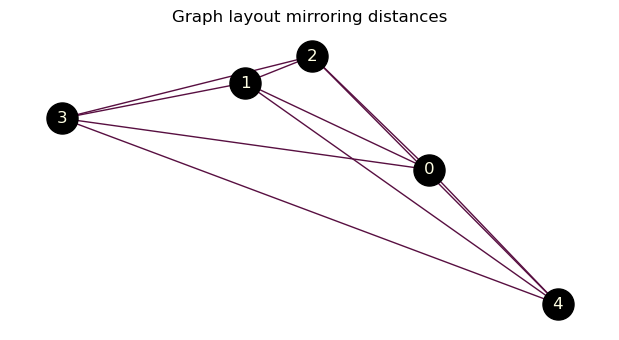

In [12]:
# Create a complete graph
G_plot = nx.complete_graph(n+1)
# Draw the graph
plt.figure(figsize=(6,3))
nx.draw(G_plot, pos={i: positions[i] for i in range(n+1)}, with_labels=True, node_color='xkcd:black', edge_color='xkcd:plum', node_size=500, font_color='xkcd:off white')
plt.title("Graph layout mirroring distances")
plt.show()

<div class="alert alert-block alert-warning">
At last costs are fixed:
    
* $\kappa_0$ is the daily cost of operations,
* $\kappa_1$ is the cost of hiring a vehicle,
* $\kappa_2$ is the cost of hiring a pollster.
</div>

In [13]:
κ_0 = 300.0
κ_1 = 100.0
κ_2 = 80.0

## Multigraph

<div class="alert alert-block alert-warning">
The networks for vehicles and pollsters is defined.
</div>

In [14]:
m = 2*n

# Domain for vehicles.                         Graph size:    (2*n) * (n + 1) + (2*n-1) * n = 4*(n**2) + n
dom_v  = [ (0,j)   for j in range(1,m+1) ] 
dom_v += [ (j,m+1) for j in range(1,m+1) ]
dom_v += [ (i,j)   for i in range(1,m+1) for j in range(1,m+1) if j not in [i,i-n]]

# Domain for pollsters.                        Graph size:    (n-1)**2 + (n-1) + n = n**2
dom_e  = [ (i,i+n) for i in range(  1,n+1) ]
dom_e += [ (i,j)   for i in range(1+n,m+1) for j in range(1,n+1) if j!=i-n ]

In [15]:
C_minus, C_plus, C_0, C_m, C = range(1,n+1), range(n+1,2*n+1),  range(0,n+1), range(1,2*n+2),  range(1,2*n+1)

## Integer Programming Model

In [16]:
mo = Model()
x, y, z, b, f, w, B, u = {}, {}, {}, {}, {}, {}, {}, {}

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-19


### Variables and Objective

In [17]:
# Pollster variables
## Nodes
b = mo.addVars( C_minus, E, S, vtype = 'B', name ='b')             # **begining**    n * |S|*|E|
f = mo.addVars( C_plus,  E, S, vtype = 'B', name ='f')             # **ending**      n * |S|*|E|
w = mo.addVars( C_minus, E, S, vtype = 'B', name ='w')             # **break**       n * |S|*|E|
## Arcs
x = mo.addVars( dom_e, E, S, vtype = 'B', name = 'x')              # **Walking paths**     n^2 * |S|*|E|

# Vehicle variables
y = mo.addVars( dom_v, K, S, vtype = 'B', name = 'y')               # **Vehicle-paths**     (4*n^2+n)*|K|*|S|
z = mo.addVars( dom_v, E, S, vtype = 'B', name = 'z')               # **t-paths**           (4*n^2+n)*|E|*|S|

# Time and days variables
B = mo.addVars( C, vtype = 'C', name = 'B', ub  = β )               # **In-Out timing**     2*n
u = mo.addVars( S, vtype = 'B', name = 'u', obj = κ_0)              # **Day**               |S|

deque( (v.setAttr('obj', κ_1) for v in y.select(0,'*')), 0)
deque( (v.setAttr('obj', κ_2) for v in z.select(0,'*')), 0)
mo.setAttr('ModelSense', GRB.MINIMIZE)
mo.update()

### Constraints

<div class="alert alert-block alert-warning">
Pollster routing
</div>

In [18]:
# x & z vars interaction
# 1a - Exclusive attention:
mo.addConstrs( (x.sum(i,i+n,'*') == 1 for i in C_minus), name='R-1a');

# 1b,c - Flow conservation:
mo.addConstrs( (x.sum('*',i,e,s) == x[i,i+n,e,s] - b[i,e,s] for i in C_minus for s in S for e in E), name='R-1b')
mo.addConstrs( (x.sum(i,'*',e,s) == x[i-n,i,e,s] - f[i,e,s] for i in C_plus for s in S for e in E), name='R-1c')

# 1d,e,f,g — Terminal pick-up and delivery:
mo.addConstrs( (z.sum('*',i,e,s) <= 1.0 - x[i,i+n,e,s] + b[i,e,s] for i in C_minus for s in S for e in E), name='R-1d')
mo.addConstrs( (z.sum(i,'*',e,s) <= 1.0 - x[i-n,i,e,s] + f[i,e,s] for i in C_plus for s in S for e in E), name='R-1e')

mo.addConstrs( (z.sum('*',i,e,s) - z.sum(i,'*',e,s) == b[i,e,s] for i in C_minus for s in S for e in E), name='R-1f')
mo.addConstrs( (z.sum('*',i,e,s) - z.sum(i,'*',e,s) == -f[i,e,s] for i in C_plus for s in S for e in E), name='R-1g')

# 1h – One trip per day for each pollster
mo.addConstrs( (z.sum(0,'*',e,s) <= u[s] for s in S for e in E), name='R-1h');

<div class="alert alert-block alert-warning">
Vehicle routing
</div>

In [19]:
# y & z vars interaction
# 2a,b - Terminal arrivals:
mo.addConstrs( (y.sum(i,'*','*',s) == b.sum(i,'*',s) for i in C_minus for s in S), name='R-2a')
mo.addConstrs( (y.sum(i,'*','*',s) == f.sum(i,'*',s) for i in C_plus for s in S), name='R-2b')
# 2c,d – Flow conservation:
mo.addConstrs( (y.sum('*',i,k,s) == y.sum(i,'*',k,s) for i in C for k in K for s in S ), name='R-2c')
mo.addConstrs( (y.sum('*',2*n+1,k,s) == y.sum(0,'*',k,s) for k in K for s in S ), name='R-2d')
# 2e – One trip per day for each vehicle:
mo.addConstrs( (y.sum(0,'*',k,s) <= u[s] for k in K for s in S ), name='R-2e')
# 2f – Capacity load:
mo.addConstrs( (z.sum(i,j,'*',s) <= Q*y.sum(i,j,'*',s) for (i,j) in dom_v for s in S ), name='R-2f');

<div class="alert alert-block alert-warning">
Time management and shift lengths
</div>

In [20]:
M = 1e+4

In [21]:
# B vars enforce connected paths
# 3a,b – Arriving marker:
mo.addConstrs( (B[i+n] - B[i] - d[i] >= P*w.sum(i,'*') for i in C_minus ), name='R-3a')
mo.addConstrs( (B[j] - B[i+n] - t[i-1,j-1] >= -M*(1.0 - x.sum(i+n,j,'*')) 
               for i in C_minus for j in C_minus if j!=i ), name='R-3b')
## Trivial
mo.addConstrs( (B[i+n] - B[i] >= 0.0 for i in C_minus ), name='R-3-o')
# 3c — Arrival after transport:
mo.addConstrs( 
   (B[j] - B[i] + M*(1.0 - y.sum(i,j,'*')) >= τ[i % (n+1) + (1 if i > n else 0), j % (n+1) + (1 if j > n else 0)] 
     for (i,j) in dom_v if i!=0 and j!=2*n+1 ), name='R-3c')
# 3d — First transportation:
mo.addConstrs( (B[i] >= τ[0, i % (n+1) + (1 if i > n else 0)] - β*(1.0 - y.sum(0,i,'*','*')) 
               for i in C ), name='R-3d')
# 3e — Arrival marks:
mo.addConstrs( ( β - B[i] >= τ[i % (n+1) + (1 if i > n else 0),0] - M*(1.0 - y.sum(i,2*n+1,'*','*'))
               for i in C ), name='R-3e');

<div class="alert alert-block alert-warning">
Pollster breaks
</div>

In [22]:
# w vars interact
# 4a — Breaks TW:
mo.addConstrs( (ρ_0*w.sum(i,'*') - B[i] - d[i] <= 0.0 for i in C_minus ), name='R-4a0')
mo.addConstrs( (B[i] + d[i] - ρ_1 - β*(1.0 - w.sum(i,'*')) <= 0.0 for i in C_minus ), name='R-4a1')
# 4b – One break per pollster:
mo.addConstrs( (w[i,e,s] <= x[i,i+n,e,s] for i in C_minus for e in E for s in S ), name='R-4b')
# 5c — Mandatory breaks:
mo.addConstrs( (w.sum('*',e,s) == z.sum(0,'*',e,s) for e in E for s in S ), name='R-4b')

mo.update()

<div class="alert alert-block alert-warning">
Symmetry inequalities
</div>

In [23]:
# More
mo.addConstr( z.sum(0,'*',0,0) == 1 , name='R-5a')
mo.addConstr( y.sum(0,'*',0,0) == 1 , name='R-5d')

if E.size > 1:
    mo.addConstrs( (z.sum(0,'*',e,s) <= z.sum(0,'*',e-1,s) for e in E for s in S if e > 0 ), name='R-5b');
    
    if S.size > 1:
        mo.addConstrs( 
            (b.sum('*',e,s) <= n - quicksum(b[i,e-1,r] for i in C_minus for r in S if r<=s-1) 
             for e in E for s in S if e > 0 if s > 0 ), name='R-5k')
        mo.addConstrs( 
            (f.sum('*',e,s) <= n - quicksum(f[i,e-1,r] for i in C_plus for r in S if r<=s-1) 
             for e in E for s in S if e > 0 if s > 0 ), name='R-5l');
        
if S.size > 1:
    mo.addConstrs( (z.sum(0,'*',e,s) <= z.sum(0,'*',e,s-1) for e in E for s in S if s > 0 ), name='R-5c')
    mo.addConstrs( (y.sum(0,'*',k,s) <= y.sum(0,'*',k,s-1) for k in K for s in S if s > 0 ), name='R-5f')
    mo.addConstrs( (b.sum(i,'*',s) <= 1.0 - b.sum(i,'*',s-1) for i in C_minus for s in S if s > 0 ), name='R-5g')
    mo.addConstrs( (f.sum(i,'*',s) <= 1.0 - f.sum(i,'*',s-1) for i in C_plus  for s in S if s > 0 ), name='R-5h')
    mo.addConstrs( (x.sum('*',i,'*',s) <= 1.0 - b.sum(i,'*',s-1) for i in C_minus for s in S if s > 0 ), name='R-5i')
    mo.addConstrs( (x.sum(i,'*','*',s) <= 1.0 - f.sum(i,'*',s-1) for i in C_plus  for s in S if s > 0 ), name='R-5j')
    mo.addConstrs( (u[s] <= u[s-1] for s in S if s > 0), name='R-5m');
    
if K.size > 1:
    mo.addConstrs( (y.sum(0,'*',k,s) <= y.sum(0,'*',k-1,s) for k in K for s in S if k > 0 ), name='R-5e');

## Optimization

In [24]:
mo.Params.TimeLimit = 3600
mo.optimize()

Set parameter TimeLimit to value 3600
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.2.0 24C101)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  3600

Optimize a model with 441 rows, 666 columns and 3282 nonzeros
Model fingerprint: 0xcb87e789
Variable types: 8 continuous, 658 integer (658 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [8e+01, 3e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 1e+04]
Presolve removed 27 rows and 41 columns
Presolve time: 0.02s
Presolved: 414 rows, 625 columns, 2950 nonzeros
Variable types: 8 continuous, 617 integer (617 binary)

Root relaxation: objective 4.800000e+02, 233 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  480.00000   

In [25]:
#mo.write('Example_Instance_'+ str(n) +'.lp')

## Results

<div class="alert alert-block alert-warning">
We identify variables that have assigned a non-zero value.
</div>

In [26]:
X = tupledict({nn: v for nn, v in x.items() if v.x > 0.0})
Y = tupledict({nn: v for nn, v in y.items() if v.x > 0.0})
Z = tupledict({nn: v for nn, v in z.items() if v.x > 0.0})

A = tupledict({nn: v for nn, v in b.items() if v.x > 0.0})
F = tupledict({nn: v for nn, v in f.items() if v.x > 0.0})
W = tupledict({nn: v for nn, v in w.items() if v.x > 0.0})
U = tupledict({nn: v for nn, v in u.items() if v.x > 0.0})

The last dictionary, `U`, contains which days are active. As a result, we can store only those days. Moreover, this also simplifies iterations. A similar treatment can be done with `E` and `K`.

In [27]:
Active_Days      = U.keys()
Active_Pollsters = {v[1] for v in A.keys()}
Active_Vehicles  = {v[2] for v in Y.keys()}

In [28]:
print('A solution was found with',len(Active_Pollsters),'pollsters,',len(Active_Vehicles),'vehicles, and',len(Active_Days),'days.')

A solution was found with 2 pollsters, 1 vehicles, and 1 days.


We can display the results:

In [29]:
E_Routes = {}
for a, b, c in [a[:3] for a in X.keys()]:
    if c not in E_Routes:
        E_Routes[c] = []
    E_Routes[c].append((a, b))

In [30]:
# Represent pedestrian paths
for pollster in E_Routes.keys():
    print('Pollster {0}: '.format(pollster))
    first_elements, second_elements = {a for a, _ in E_Routes[pollster]}, {b for _, b in E_Routes[pollster]}
    starting_nodes = list(first_elements - second_elements)

    for k in range(len(starting_nodes)):
        node = starting_nodes[k]
        print('   Route {0}: '.format(k), node,'→ ', end ='')
        for a in range(len(E_Routes[pollster])):
            find_tuple = next((i for i in E_Routes[pollster] if i[0] == node), None)
            node = find_tuple[1]
            print(node,'→ ', end ='') if (node in first_elements) else print(node)
            if (node not in first_elements):
                break

Pollster 0: 
   Route 0:  1 → 5 → 2 → 6
Pollster 1: 
   Route 0:  3 → 7
   Route 1:  4 → 8


In [31]:
V_Visits = [a[:2] for a in Y.keys()]
# Represent vehicle path
node = 0
print(node,'→ ', end ='')
for a in range(len(V_Visits)):
    find_tuple = next((i for i in V_Visits if i[0] == node), None)
    node = find_tuple[1]
    print(node,'→ ', end ='') if node < 2*n+1 else print(node)

0 → 1 → 4 → 8 → 3 → 7 → 6 → 9


In [32]:
# Pause at which store?
for a in [a[:2] for a in W.keys()]:
    print('Pollster {0}: {1}'.format(a[1], a[0]))

Pollster 0: 2
Pollster 1: 3


## Export

In [ ]:
Out_File = 'Results_'+ str(n) +'.xlsx'

In [ ]:
with pd.ExcelWriter(Out_File) as writer:
    # General results
    Hoja = DataFrame({'0':['Active days','Active pollsters','Active vehicles', 'Objective','GAP'], 
                      '1':[len(U), len(Active_Pollsters), len(Active_Vehicles), mo.ObjVal, str(around(mo.MIPGap * 100,2)) + ' %']})
    Hoja.to_excel(writer, 'Summary', header=False, index= False)
    writer.sheets['Summary'].set_column('A:A', 15)
    
    # Pollster routing
    X_visits = [zeros([n+1,n+1], dtype=int) for days in Active_Days]
    for days in Active_Days:
        X_day = (v[:-1] for v in X.keys() if v[-1] == days)
        for pairs in X_day:
            coords = tuple([vv if vv <= n else vv%n if vv<2*n else n for vv in pairs[:-1] ])
            X_visits[days][coords] = pairs[-1] + 1
            
    Hoja = concat([DataFrame(X_visits[days]) for days in Active_Days], axis=1).replace({0:''})
    Hoja.columns = [str(v) + ' day ' + str(days) for days in Active_Days for v in C_0 ]
    Hoja.to_excel(writer, 'Pollster routing')
    
    # Vehicle routing
    Y_visits = [zeros([n+1,n+1], dtype=int) for days in Active_Days]
    for days in Active_Days:
        Y_day = (v[:-1] for v in Y.keys() if v[-1] == days)
        for pairs in Y_day:
            coords = tuple([vv if vv <= n else vv%n if vv<2*n else n if vv == 2*n else 0 for vv in pairs[:-1] ])
            Y_visits[days][coords] = pairs[-1] + 1
    
    Hoja = concat([DataFrame(Y_visits[days]) for days in Active_Days], axis=1).replace({0:''})
    Hoja.columns = [str(v) + ' day ' + str(days) for days in Active_Days for v in C_0 ]
    Hoja.to_excel(writer, 'Vehicle routing')
    
    # Shared routing
    Z_visits = [zeros([n+1,n+1], dtype='<U'+str(2*n)) for days in Active_Days]
    for days in Active_Days:
        Z_day = (v[:-1] for v in Z.keys() if v[-1] == days)
        for pairs in Z_day:
            coords = tuple([vv if vv <= n else vv%n if vv<2*n else n if vv == 2*n else 0 for vv in pairs[:-1] ])
            if Z_visits[days][coords] == '':
                Z_visits[days][coords] = str(pairs[-1] + 1)
            else:
                Z_visits[days][coords] += ', ' + str(pairs[-1] + 1)
    
    Hoja = concat([DataFrame(Z_visits[days]) for days in Active_Days], axis=1).replace({0:''})
    Hoja.columns = [str(v) + ' day ' + str(days) for days in Active_Days for v in C_0 ]
    Hoja.to_excel(writer, 'Shared routing')
    
    # Times and breaks
    W_breaks = [ zeros(n, dtype=int) for days in Active_Days]
    for days in Active_Days:
        for v in (v[:-1] for v in W.keys() if v[-1] == days):
            W_breaks[days][v[0]-1] = v[1]+1
    
    Hoja = DataFrame({'Time i':[ B[i].x for i in C_minus ], 'Time i+n':[ B[i].x for i in C_plus ]})
    Hoja = concat([Hoja]+[DataFrame(W_breaks[days]) for days in Active_Days], axis=1).replace({0:''})
    Hoja.columns = list(Hoja.columns[:2]) + ['break day '+str(days) for days in Active_Days]
    Hoja.index = arange(1,n+1)
    Hoja.to_excel(writer, 'Times and breaks per pollster')
    writer.sheets['Times and breaks per pollster'].set_column('D:AA', 15)

---